## Basic Steps

0. Fix the paths so that they point to the directory where you have data downloaded.
1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on 
where you have them in commands.  
  - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively. Set kFeatureSliceSize to num_channels and kFeatureSliceCount to the input_shape[0] (microfrontend will extract as many frames of spectra from 1s of audio as it can.)  Also set kMaxAudioSampleSize to be the next largest power of 2 greater than or equal to kFeatureSliceDurationMs*16000/1000 (1024 in this case)
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

*Note*:  As of 5/10/21, this model uses 21% of flash and 50% of RAM, so there is substantial space to improve the model, but the latency is about 40ms.


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib

from IPython import display

2.3.2


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [59]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_channels = 30
use_microfrontend = True
dataset = 'mini-speech' #  'full-speech' # 'mini-speech' # 
silence_str = "_silence"  
unknown_str = "_unknown"
EPOCHS = 50

In [60]:
!ls /home/jeremy/data/mini_speech_commands

down  go  left	no  README.md  right  stop  up	yes


Apply the frontend to an example signal.

In [61]:
if dataset == 'mini-speech':
  data_dir = pathlib.Path(os.path.join(os.getenv("HOME"), 'data/mini_speech_commands'))
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data')
  commands = np.array(tf.io.gfile.listdir(str(data_dir)))
  # commands = commands[commands != 'README.md']
  commands = ['left', 'right']
elif dataset == 'full-speech':
  # data_dir = '/dfs/org/Holleman-Coursework/data/speech_dataset'
  data_dir = '/home/jeremy/data/speech_commands_v0.02'
  commands = ['left', 'right'] 


In [62]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)

In [63]:
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'left', 'right']


In [64]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
# with the next commented-out line, you can choose only files for words in label_list
# filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
# print('Number of examples per label:',
#       len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Example file tensor: tf.Tensor(b'/home/jeremy/data/mini_speech_commands/down/6727b579_nohash_3.wav', shape=(), dtype=string)


In [65]:
filenames
# tf.strings.split(filenames[0], os.path.sep)[-2].numpy().decode('utf8')

<tf.Tensor: shape=(8000,), dtype=string, numpy=
array([b'/home/jeremy/data/mini_speech_commands/down/6727b579_nohash_3.wav',
       b'/home/jeremy/data/mini_speech_commands/right/e649aa92_nohash_0.wav',
       b'/home/jeremy/data/mini_speech_commands/go/3f2b358d_nohash_3.wav',
       ...,
       b'/home/jeremy/data/mini_speech_commands/down/10ace7eb_nohash_0.wav',
       b'/home/jeremy/data/mini_speech_commands/left/5aac2efa_nohash_0.wav',
       b'/home/jeremy/data/mini_speech_commands/down/333784b7_nohash_2.wav'],
      dtype=object)>

In [66]:
# Not really necessary, but just look at a few of the files to make sure that 
# they're the correct files, shuffled, etc.
for i in range(10):
    print(filenames[i].numpy().decode('utf8'))

/home/jeremy/data/mini_speech_commands/down/6727b579_nohash_3.wav
/home/jeremy/data/mini_speech_commands/right/e649aa92_nohash_0.wav
/home/jeremy/data/mini_speech_commands/go/3f2b358d_nohash_3.wav
/home/jeremy/data/mini_speech_commands/no/a24cf51c_nohash_1.wav
/home/jeremy/data/mini_speech_commands/stop/46a153d8_nohash_2.wav
/home/jeremy/data/mini_speech_commands/go/df1d5024_nohash_3.wav
/home/jeremy/data/mini_speech_commands/go/8056e897_nohash_1.wav
/home/jeremy/data/mini_speech_commands/down/3847619e_nohash_0.wav
/home/jeremy/data/mini_speech_commands/stop/0135f3f2_nohash_1.wav
/home/jeremy/data/mini_speech_commands/stop/be7a5b2d_nohash_4.wav


In [67]:
if dataset == 'mini-speech':
  print('Using mini-speech')
  num_train_files = int(0.8*num_samples) 
  num_val_files = int(0.1*num_samples) 
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
elif dataset == 'full-speech':  
  # the full speech-commands set lists which files are to be used
  # as test and validation data; train with everything else
  fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
  with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
  # validation_list.txt only lists partial paths
  val_files = [os.path.join(data_dir, fn) for fn in val_files]
  fname_test_files = os.path.join(data_dir, 'testing_list.txt')

  with open(fname_test_files) as fpi_tst:
    test_files = fpi_tst.read().splitlines()
  # testing_list.txt only lists partial paths
  test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    

  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
  train_files = [f.decode('utf8') for f in filenames.numpy()]
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
  train_files = [f for f in train_files if f.split('/')[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
  train_files = list(set(train_files) - set(test_files) - set(val_files))
  # now convert back into a TF tensor so we can use the tf.dataset pipeline
  train_files = tf.constant(train_files)    
  print("Full-speech is in progress.  Good luck!")
else:
  raise ValueError("dataset must be either full-speech or mini-speech")
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800


In [68]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [69]:
# @tf.function
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [70]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [71]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_channels,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [72]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [73]:
def wavds2specds(waveform_ds):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    
  spec_shape = (0,) + one_spec.shape[1:]  # replace the 1st entry in one_spec.shape w/ 0
  spec_grams = np.zeros(spec_shape)
  labels = []
  for wav, label in waveform_ds:
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams = np.concatenate((spec_grams, spectrogram))
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels.append(new_label_id) # for numeric labels
    # labels.append(new_label) # for string labels
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

In [74]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

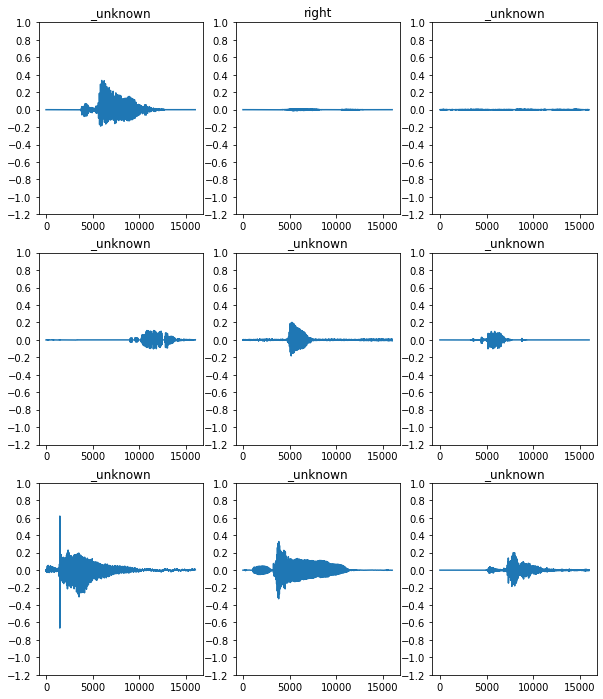

In [75]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [131]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (24, 30)
Audio playback


In [136]:
model(tf.expand_dims(tf.expand_dims(spectrogram, -1), 0).shape)

AttributeError: 'TensorShape' object has no attribute '_keras_mask'

<ipython-input-77-e1cd5567c8a2>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


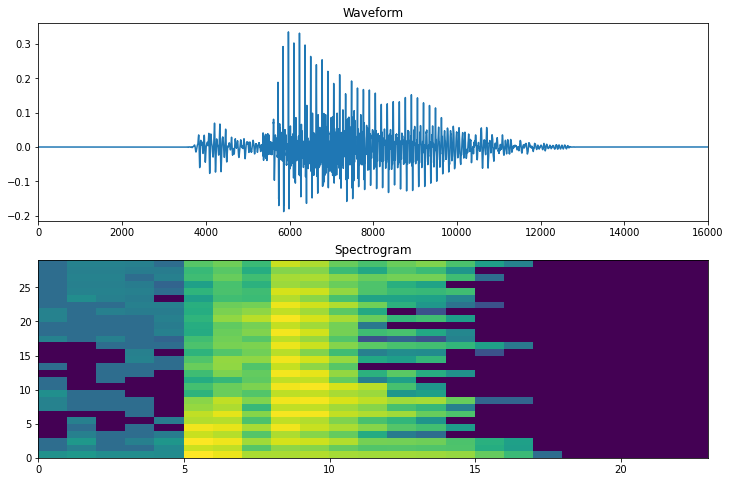

In [77]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

<ipython-input-77-e1cd5567c8a2>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


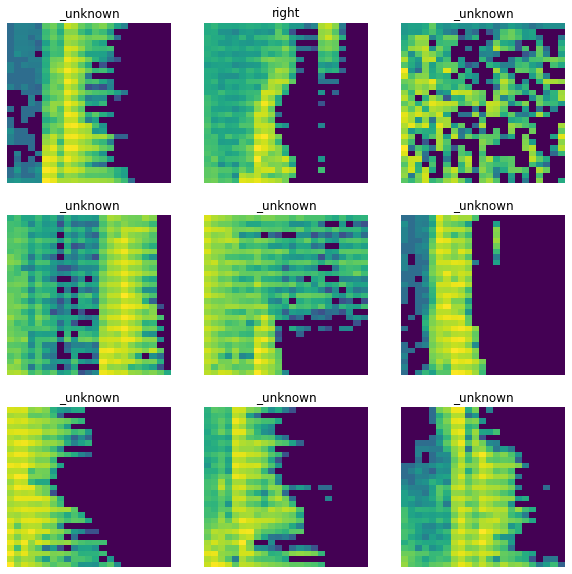

In [78]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_list[label_id.numpy()])
  ax.axis('off')

plt.show()

In [79]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [80]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

element 20 has shape (11146,)
20


In [81]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [82]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [83]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [84]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 6400/800/800 training/validation/test files


In [85]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
print(count_labels(tmp_ds))



['_silence', '_unknown', 'left', 'right']
{1: 15, 3: 5, 0: 5}
{1: 15, 3: 15, 0: 5}


In [86]:
train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [87]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set
{1: 4762, 3: 4974, 2: 4854, 0: 1281}
val_ds data set
{1: 630, 2: 88, 3: 82, 0: 161}
test_ds data set
{3: 89, 1: 608, 2: 103, 0: 161}


In [88]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [89]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [90]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [91]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (24, 30, 1)
ranges from 0.0 to 712.0


In [92]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(label_list)



Input shape: (24, 30, 1)


In [101]:
layers.MaxPooling2D?

In [111]:
## print('Input shape:', input_shape)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(20, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2', pool_size=(4,4)),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(20, 1, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="simple_cnn")

model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 22, 28, 20)        200       
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 7, 20)          0         
_________________________________________________________________
depthwise_conv2d_11 (Depthwi (None, 5, 7, 20)          200       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 7, 20)          420       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 3, 20)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 2, 3, 20)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 120)               0

In [113]:
# number of MACs in each layer is (# outputs in layer) * (number of inputs that contribute to one output)
macs = np.array([(22*28*20)*(3*3), (5*7*20)*(3*3), (5*7*20)*20, 120*128, 128*128, 4*128])
print(macs)
print(np.sum(macs))

[110880   6300  14000  15360  16384    512]
163436


In [114]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [115]:
#  Google: feature extraction with Keras
# feature_model = tf.keras.model(input=model.input, output= model.layers[4].output)

In [116]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/50
248/248 [==============================] - 1s 3ms/step - loss: 2.6867 - accuracy: 0.4429 - val_loss: 0.8497 - val_accuracy: 0.5786
Epoch 2/50
248/248 [==============================] - 1s 2ms/step - loss: 0.9905 - accuracy: 0.5184 - val_loss: 0.6948 - val_accuracy: 0.6701
Epoch 3/50
248/248 [==============================] - 1s 2ms/step - loss: 0.9070 - accuracy: 0.5446 - val_loss: 0.7004 - val_accuracy: 0.6764
Epoch 4/50
248/248 [==============================] - 1s 2ms/step - loss: 0.8365 - accuracy: 0.5779 - val_loss: 0.6617 - val_accuracy: 0.7045
Epoch 5/50
248/248 [==============================] - 1s 2ms/step - loss: 0.8113 - accuracy: 0.5889 - val_loss: 0.6862 - val_accuracy: 0.7929
Epoch 6/50
248/248 [==============================] - 1s 2ms/step - loss: 0.7734 - accuracy: 0.6172 - val_loss: 0.5444 - val_accuracy: 0.8304
Epoch 7/50
248/248 [==============================] - 1s 2ms/step - loss: 0.7382 - accuracy: 0.6421 - val_loss: 0.5589 - val_accuracy: 0.8127
Epoch 

In [117]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

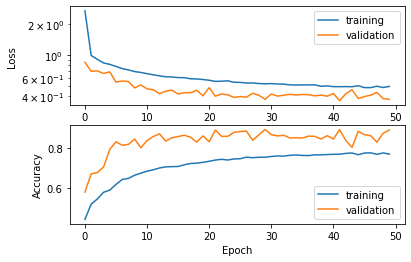

In [118]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [119]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [120]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 90%


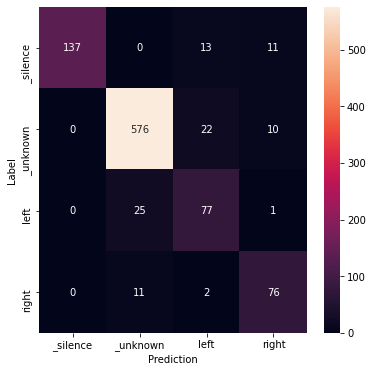

In [121]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Data set accuracy: 79%


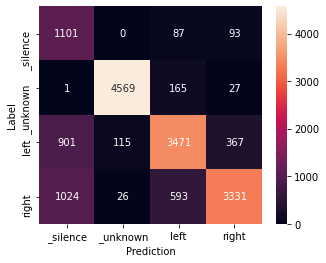

In [122]:
dset = train_ds.unbatch()

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

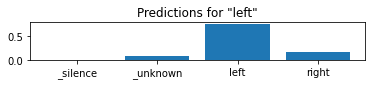

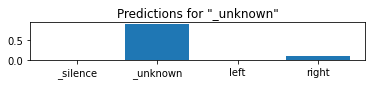

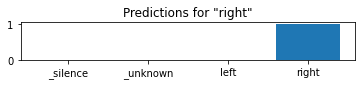

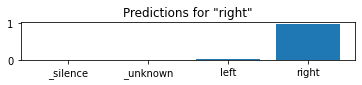

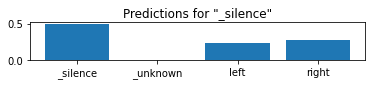

In [123]:
sample_files = [data_dir/'left/07ad9b59_nohash_0.wav', 
                data_dir/'no/01bb6a2a_nohash_0.wav',  
                data_dir/'right/0362539c_nohash_1.wav',
                data_dir/'right/b5d1e505_nohash_0.wav']
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)
count = 1
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.subplot(len(sample_files)+1, 1, count)
  plt.bar(label_list, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{label_list[label[0]]}"')
  plt.show()
  count += 1

## Quantize and Convert to TFLite

In [124]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [125]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [126]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [127]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpnqo8dcz8/assets


INFO:tensorflow:Assets written to: /tmp/tmpnqo8dcz8/assets


In [128]:
fname = 'kws_model.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 41504 / 41504 bytes to tflite file


In [129]:
!xxd -i kws_model.tflite

unsigned char kws_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x8c, 0xa1, 0x00, 0x00, 0x78, 0x88, 0x00, 0x00, 0x60, 0x88, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x04, 0x00, 0x08, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x19, 0x00, 0x00, 0x00, 0x0c, 0x88, 0x00, 0x00, 0xf8, 0x87, 0x00, 0x00,
  0x8c, 0x87, 0x00, 0x00, 0x18, 0x87, 0x00, 0x00, 0x04, 0x85, 0x00, 0x00,
  0xf0, 0x82, 0x00, 0x00, 0xcc, 0x82, 0x00, 0x00, 0xa8, 0x82, 0x00, 0x00,
  0x94, 0x46, 0x00, 0x00, 0x80, 0x06, 0x00, 0x00, 0x6c, 0x04, 0x00, 0x00,
 